In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Importing WeatherBench data

In [2]:
zarr_path = "gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr"
ds = xr.open_zarr(zarr_path, chunks="auto", storage_options={'token': 'anon'})

print(ds)

<xarray.Dataset> Size: 2TB
Dimensions:                                           (time: 93544,
                                                       longitude: 240,
                                                       latitude: 121, level: 13)
Coordinates:
  * time                                              (time) datetime64[ns] 748kB ...
  * longitude                                         (longitude) float64 2kB ...
  * latitude                                          (latitude) float64 968B ...
  * level                                             (level) int64 104B 50 ....
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 11GB ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 11GB ...
    10m_wind_speed                                    (time, longitude, latitude) float32 11GB ...
    2m_dewpoint_temperature                           (time, longitude, latitude) float3

In [3]:
list(ds.data_vars)

['10m_u_component_of_wind',
 '10m_v_component_of_wind',
 '10m_wind_speed',
 '2m_dewpoint_temperature',
 '2m_temperature',
 'above_ground',
 'ageostrophic_wind_speed',
 'angle_of_sub_gridscale_orography',
 'anisotropy_of_sub_gridscale_orography',
 'boundary_layer_height',
 'divergence',
 'eddy_kinetic_energy',
 'geopotential',
 'geopotential_at_surface',
 'geostrophic_wind_speed',
 'high_vegetation_cover',
 'integrated_vapor_transport',
 'lake_cover',
 'land_sea_mask',
 'lapse_rate',
 'leaf_area_index_high_vegetation',
 'leaf_area_index_low_vegetation',
 'low_vegetation_cover',
 'mean_sea_level_pressure',
 'mean_surface_latent_heat_flux',
 'mean_surface_net_long_wave_radiation_flux',
 'mean_surface_net_short_wave_radiation_flux',
 'mean_surface_sensible_heat_flux',
 'mean_top_downward_short_wave_radiation_flux',
 'mean_top_net_long_wave_radiation_flux',
 'mean_top_net_short_wave_radiation_flux',
 'mean_vertically_integrated_moisture_divergence',
 'potential_vorticity',
 'relative_humidi

We are assessing the spatial resolution, temporal resolution, approximate dataset size, and the geographic coordinates for New Orleans as the focus for this project.

In [4]:
# A degree of latitude = 111 km
lat = ds.latitude.values
lon = ds.longitude.values
dlat = np.abs(lat[1] - lat[0])
dlon = np.abs(lon[1] - lon[0])
print(f"Spatial resolution: {dlat:.2f}° lat x {dlon:.2f}° lon")

Spatial resolution: 1.50° lat x 1.50° lon


In [5]:
times = pd.to_datetime(ds.time.values)
time_diffs = np.diff(times) / np.timedelta64(1, "h")
unique_intervals = np.unique(time_diffs)
print(f"Temporal resolution: {unique_intervals[0]} hours between timesteps")

Temporal resolution: 6.0 hours between timesteps


In [6]:
ds_size_gb = ds.nbytes / 1e9
print(f"Approximate dataset size: {ds_size_gb:.2f} GB (in-memory estimate, compressed on GCS)")

Approximate dataset size: 2488.33 GB (in-memory estimate, compressed on GCS)


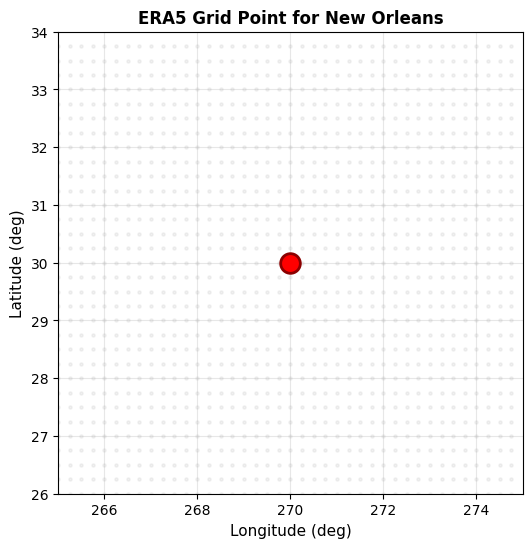

In [7]:
# Subset bounds (ERA5 longitudes are 0-360)
lat_nola= 29.95
lon_nola = 269.93

# Adjust latitude slice if descending
ds_region = ds.sel(
    longitude=lon_nola,
    latitude=lat_nola,
    method='nearest'  # Finds the closest grid point
)

lon_nola = ds_region.longitude.values
lat_nola = ds_region.latitude.values

# Create 2D grid for plotting
lon2d, lat2d = np.meshgrid(ds_region.longitude.values, ds_region.latitude.values)

plt.figure(figsize=(6, 6))
plt.scatter(lon_nola, lat_nola, s=200, color='red',  
            edgecolors='darkred', linewidth=2, label='New Orleans', zorder=3)

# Add context - show surrounding region
lon_context = np.arange(265, 275, 0.25)
lat_context = np.arange(26, 34, 0.25)
lon2d_context, lat2d_context = np.meshgrid(lon_context, lat_context)
plt.scatter(lon2d_context.ravel(), lat2d_context.ravel(), s=5, color='lightgray', alpha=0.3)

plt.xlabel('Longitude (deg)', fontsize=11)
plt.ylabel('Latitude (deg)', fontsize=11)
plt.title('ERA5 Grid Point for New Orleans', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xlim(265, 275)
plt.ylim(26, 34)
plt.show()

# Print data dimensions
#print(f"\nDataset dimensions after selection:")
#print(f"  Single point: {actual_lat}°N, {actual_lon}°E")
#print(f"  Time steps: {len(ds_region.time)}")
#print(f"  Levels: {len(ds_region.level) if 'level' in ds_region.dims else 'N/A'}")
#print(f"Number of grid points in the subset: {lon2d.size}")

The below code will be focusing on using a single point (New Orleans) to predict single-point precipitation and train a model to predict day t+3 directly. Will build separate lead times for t+3 days

In [9]:
# lons = lon2d.flatten()
# lats = lat2d.flatten()

# def create_kml(lons, lats, filename='grid_points.kml'):
#     kml_header = '''<?xml version="1.0" encoding="UTF-8"?>
#     <kml xmlns="http://www.opengis.net/kml/2.2">
#       <Document>
#         <name>Grid Points</name>'''

#     kml_footer = '''
#       </Document>
#     </kml>'''

#     kml_placemarks = ''
#     for lon, lat in zip(lons, lats):
#         placemark = f'''
#         <Placemark>
#           <Point>
#             <coordinates>{lon},{lat},0</coordinates>
#           </Point>
#         </Placemark>'''
#         kml_placemarks += placemark

#     kml_content = kml_header + kml_placemarks + kml_footer

#     with open(filename, 'w') as f:
#         f.write(kml_content)
#     print(f"KML file saved to {filename}")

# # Usage
# create_kml(lons, lats, 'era5_grid_points.kml')

In [8]:
ds_region_size_gb = ds_region.nbytes / 1e9
print(f"Approximate dataset size: {ds_region_size_gb:.2f} GB (in-memory estimate, compressed on GCS)")

Approximate dataset size: 0.09 GB (in-memory estimate, compressed on GCS)


In [9]:
selected_variables = [
    'specific_humidity',
    'vertical_velocity',
    'temperature',
    'relative_humidity',
    'geopotential',
    'mean_vertically_integrated_moisture_divergence',
    'u_component_of_wind',
    'v_component_of_wind',
    'potential_vorticity',
    'divergence',
    'total_precipitation_6hr'
]

ds_sub = ds_region[selected_variables]

In [10]:
ds_sub_size_gb = ds_sub.nbytes / 1e9
print(f"Approximate dataset size: {ds_sub_size_gb:.2f} GB (in-memory estimate, compressed on GCS)")

Approximate dataset size: 0.05 GB (in-memory estimate, compressed on GCS)


In [11]:
agg_funcs = {
    'specific_humidity': 'mean',
    'vertical_velocity': 'mean',
    'temperature': 'mean',
    'relative_humidity': 'mean',
    'geopotential': 'mean',
    'u_component_of_wind': 'mean',
    'v_component_of_wind': 'mean',
    'divergence': 'mean',
    'total_precipitation_6hr': 'sum'
}

In [ ]:
#Dataset information
ds_sub = ds_sub.sel(time=slice("1990-01-01", "2020-12-31"))

print(ds_sub)

if 'latitude' in ds_sub.dims:
    print(f"Spatial dimensions: {len(ds_sub.latitude)} x { len(ds_sub.longitude)}")
elif 'latitude' in ds_sub.coords:
    # Single point - latitude and longitude are scalar coordinates
    print(f"\nSingle spatial point: {ds_sub.latitude.values}°N, {ds_sub.longitude.values}°E")
    print(f"(or {ds_sub.longitude.values - 360}°W)")
else:
    print("\nNo spatial dimensions found")

#Additional info
print(f"Time range: {ds_sub.time.values[0]} to {ds_sub.time.values[-1]}")
print(f"Total timesteps: {len(ds_sub.time)}")
if 'level' in ds_sub.dims:
    print(f"Pressure levels: {len(ds_sub.level)}")


<xarray.Dataset> Size: 22MB
Dimensions:                                         (time: 45292, level: 13)
Coordinates:
  * time                                            (time) datetime64[ns] 362kB ...
  * level                                           (level) int64 104B 50 ......
    latitude                                        float64 8B 30.0
    longitude                                       float64 8B 270.0
Data variables:
    specific_humidity                               (time, level) float32 2MB ...
    vertical_velocity                               (time, level) float32 2MB ...
    temperature                                     (time, level) float32 2MB ...
    relative_humidity                               (time, level) float32 2MB ...
    geopotential                                    (time, level) float32 2MB ...
    mean_vertically_integrated_moisture_divergence  (time) float32 181kB ...
    u_component_of_wind                             (time, level) float32 2MB

In [ ]:
print("CHECKING FOR MISSING VALUES AND OUTLIERS")
for var in ds_sub.data_vars:
    print(f"\n{var}:")
    
    data = ds_sub[var].values
    total = data.size
    
    #checking for nan
    nan_count = np.isnan(data).sum()
    nan_pct = 100 * nan_count / total
    print(f"  Missing values: {nan_count:,} ({nan_pct:.2f}%)")

    data_clean = data[~np.isnan(data)]
    
    if len(data_clean) > 0:
        mean = np.mean(data_clean)
        std = np.std(data_clean)
        min_val = np.min(data_clean)
        max_val = np.max(data_clean)
        
        print(f"  Range: [{min_val:.4f}, {max_val:.4f}]")
        print(f"  Mean ± Std: {mean:.4f} ± {std:.4f}")
        
        #checking outliers for extreme values
        q1 = np.percentile(data_clean, 25)
        q3 = np.percentile(data_clean, 75)
        iqr = q3 - q1
        
        lower_bound = q1 - 3 * iqr
        upper_bound = q3 + 3 * iqr
        
        outliers = ((data_clean < lower_bound) | (data_clean > upper_bound)).sum()
        outlier_pct = 100 * outliers / len(data_clean)
        
        print(f"  Outliers (3*IQR method): {outliers:,} ({outlier_pct:.2f}%)")
        print(f"  Outlier bounds: [{lower_bound:.4f}, {upper_bound:.4f}]")
        


CHECKING FOR MISSING VALUES AND OUTLIERS

specific_humidity:
  Missing values: 0 (0.00%)
  Range: [-0.0000, 0.0218]
  Mean ± Std: 0.0028 ± 0.0045
  Outliers (3*IQR method): 20,250 (3.44%)
  Outlier bounds: [-0.0111, 0.0148]

vertical_velocity:
  Missing values: 0 (0.00%)
  Range: [-5.0598, 1.7751]
  Mean ± Std: -0.0046 ± 0.1565
  Outliers (3*IQR method): 20,997 (3.57%)
  Outlier bounds: [-0.3222, 0.3378]

temperature:
  Missing values: 0 (0.00%)
  Range: [188.9319, 307.3945]
  Mean ± Std: 249.1953 ± 32.4730
  Outliers (3*IQR method): 0 (0.00%)
  Outlier bounds: [24.7794, 471.4811]

relative_humidity:
  Missing values: 0 (0.00%)
  Range: [-0.1094, 1.0751]
  Mean ± Std: 0.3656 ± 0.2816
  Outliers (3*IQR method): 0 (0.00%)
  Outlier bounds: [-1.4017, 2.1118]

geopotential:
  Missing values: 0 (0.00%)
  Range: [-3019.1257, 205535.9688]
  Mean ± Std: 80841.1328 ± 60390.7266
  Outliers (3*IQR method): 0 (0.00%)
  Outlier bounds: [-242372.8594, 394534.2500]

mean_vertically_integrated_moistur

Exploring the columns in the Thermodynamic list

In [16]:
#making variable subsets to test EDA speed
variable_subset = {
    'moisture':['mean_vertically_integrated_moisture_divergence','total_precipitation_6hr'],
    'dynamic':['u_component_of_wind','v_component_of_wind','vertical_velocity'],
    'derived':['geopotential','potential_vorticity','divergence'],
    'thermodynamic':['temperature','specific_humidity','relative_humidity']
}

group1 = 'thermodynamic'
var1 = variable_subset[group1]

print(f"Variable subset: {var1}")
ds_subset = ds_sub[var1]

Variable subset: ['temperature', 'specific_humidity', 'relative_humidity']


In [ ]:
for var in var1:
    # This navigates the subsetted data and checks for every n'th day (aka timestep)
    sample = ds_subset[var].isel(time=slice(0, None, 1))
    data = sample.values
    
    print(f"\n{var}:")
    
    #With 0 Celsius = -273.15 K
    if var == 'temperature':
        data_celsius = data - 273.15 #conversion rate

        #stats for temp exclusively
        print(f"  Mean: {np.nanmean(data_celsius):.2f} °C")
        print(f"  Std: {np.nanstd(data_celsius):.2f} °C")
        print(f"  Min: {np.nanmin(data_celsius):.2f} °C")
        print(f"  Max: {np.nanmax(data_celsius):.2f} °C")
    else:
        #stats for others in var1
        print(f"  Mean: {np.nanmean(data):.2f}")
        print(f"  Std: {np.nanstd(data):.2f}")
        print(f"  Min: {np.nanmin(data):.2f}")
        print(f"  Max: {np.nanmax(data):.2f}")
    
    # Show data shape
    print(f"  Shape: {data.shape}")


temperature:
  Mean: -23.9668 °C (249.1832 K)
  Std: 32.4503 °C
  Min: -83.2646 °C
  Max: 32.4548 °C
  Shape: (4530, 13)

specific_humidity:
  Mean: 0.0028
  Std: 0.0045
  Min: 0.0000
  Max: 0.0211
  Shape: (4530, 13)

relative_humidity:
  Mean: 0.3701
  Std: 0.2837
  Min: 0.0033
  Max: 1.0593
  Shape: (4530, 13)


In [32]:
#Attempt at creating a baseline model from the above LinReg

train_range = slice('1990','2010')
validation_range = slice('2011', '2018')
test_range = slice('2019','2020')

In [34]:
ds_train = ds_sub.sel(time= train_range)
ds_val = ds_sub.sel(time = validation_range)
ds_test = ds_sub.sel(time = test_range)

print("Data Splits: ")
print(f" Training Duration: {ds_train.time.values[0]} - {ds_train.time.values[-1]}")
print(f" Testing Duration: {ds_test.time.values[0]} - {ds_test.time.values[-1]}")
print(f" Validation Duration: {ds_val.time.values[0]} - {ds_val.time.values[-1]}")

Data Splits: 
 Training Duration: 1990-01-01T00:00:00.000000000 - 2010-12-31T18:00:00.000000000
 Testing Duration: 2019-01-01T00:00:00.000000000 - 2020-12-31T18:00:00.000000000
 Validation Duration: 2011-01-01T00:00:00.000000000 - 2018-12-31T18:00:00.000000000


In [66]:
print(ds_train) #remove mean_vertically_integrated_moisture_divergence across all 3

<xarray.Dataset> Size: 15MB
Dimensions:                                         (time: 30680, level: 13)
Coordinates:
  * time                                            (time) datetime64[ns] 245kB ...
  * level                                           (level) int64 104B 50 ......
    latitude                                        float64 8B 30.0
    longitude                                       float64 8B 270.0
Data variables:
    specific_humidity                               (time, level) float32 2MB ...
    vertical_velocity                               (time, level) float32 2MB ...
    temperature                                     (time, level) float32 2MB ...
    relative_humidity                               (time, level) float32 2MB ...
    geopotential                                    (time, level) float32 2MB ...
    mean_vertically_integrated_moisture_divergence  (time) float32 123kB nan ...
    u_component_of_wind                             (time, level) float32

In [ ]:
#Creating Lag and Why?
#Allows the model to use recent historic data as reference when assessing new data
def time_lag(ds, features, goal, lag_steps= 1, lead_steps=12):

    """
    time_lag creates lagged inputs up to 72 hours ahead of time (lead_steps = 12; 6 hours * 12 = 72 hours)
    """
    n_days = len(ds.time)
    start = lag_steps
    end = n_days - lead_steps 

    ds_list = []

    for var in features:
        
        if 'level' in ds[var].dims:
            var_data = ds[var].mean(dim='level').values
        else:
            var_data = ds[var].values

        lags = var_data[start - lag_steps : end - lag_steps]
        ds_list.append(lags)

    d = np.column_stack(ds_list) #stacking features collected in the loop

    if 'level' in ds[goal].dims:
        target_data = ds[goal].mean(dim='level').values
    else:
        target_data = ds[goal].values

    y = target_data[start + lead_steps : end + lead_steps]
    
    return pd.DataFrame(d), y


Need to standardize the data due to the different metrics each column uses. Importing StandardScaler to fix incorrect error metrics.

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

LINEAR REGRESSION BASELINE MODEL

In [ ]:
feature_vars = ['temperature', 'specific_humidity', 'relative_humidity','vertical_velocity','geopotential','u_component_of_wind','v_component_of_wind','divergence','total_precipitation_6hr']
target_var = 'total_precipitation_6hr'
lag_steps = 1   # Use t-1 (6 hours ago)
lead_times= [1,2,3,4,5,6,7,8,9,10,11,12]  # Predict t+3 (18 hours ahead)

print("This is the start of SINGLE-STEP forecasting for t+3 days")

ss_model = {}
ss_scaler = {}
metrics = {}

for ls in lead_times:
    X_train, y_train = time_lag(ds_train, feature_vars, target_var, lag_steps, ls)
    X_val, y_val = time_lag(ds_val, feature_vars, target_var, lag_steps, ls)
    X_test, y_test = time_lag(ds_test, feature_vars, target_var, lag_steps, ls)

    print(f"Train samples: {X_train.shape[0]}")
    print(f"  Val samples:   {X_val.shape[0]}")
    print(f"  Test samples:  {X_test.shape[0]}")

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)

    y_train_pred = lr_model.predict(X_train_scaled)
    y_val_pred = lr_model.predict(X_val_scaled)
    y_test_pred = lr_model.predict(X_test_scaled)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))

    ss_model[ls] = lr_model
    ss_scaler[ls] = scaler
    metrics[ls] = {
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'train_rmse':train_rmse,
        'val_rmse':val_rmse,
        'test_rmse':test_rmse
    }

    print(f"Training MAE: {train_mae:.4f} m ({train_mae*1000:.3f} mm)")
    print(f"Testing MAE: {test_mae:.4f} m ({test_mae*1000:.3f} mm)")
    print(f"Validation MAE: {val_mae:.4f} m ({val_mae*1000:.3f} mm)")
    print(f"Training RMSE: {train_rmse:.4f} m ({train_rmse*1000:.3f} mm)")
    print(f"Testing RMSE: {test_rmse:.4f} m ({test_rmse*1000:.3f} mm)")
    print(f"Validation RMSE: {val_rmse:.4f} m ({val_rmse*1000:.3f} mm)")


#looping to output all metrics as a dataframe
comparison_data = []
for ls in lead_times:
    comparison_data.append({
        'Lead Time': f't+{ls}',
        'Hours Ahead': ls * 6,
        'Test MAE (mm)': f"{metrics[ls]['test_mae']*1000:.3f}",
        'Test RMSE (mm)': f"{metrics[ls]['test_rmse']*1000:.3f}",
        'Training MAE (mm)': f"{metrics[ls]['train_mae']*1000:.3f}",
        'Training RMSE (mm)': f"{metrics[ls]['train_rmse']*1000:.3f}",
        'Validation MAE (mm)': f"{metrics[ls]['val_mae']*1000:.3f}",
        'Validation RMSE (mm)': f"{metrics[ls]['val_rmse']*1000:.3f}"
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison



This is the start of SINGLE-STEP forecasting for t+3 days
Train samples: 30678
  Val samples:   11686
  Test samples:  2922
Training MAE: 0.0012 m (1.223 mm)
Testing MAE: 0.0013 m (1.308 mm)
Validation MAE: 0.0013 m (1.275 mm)
Training RMSE: 0.0025 m (2.499 mm)
Testing RMSE: 0.0025 m (2.469 mm)
Validation RMSE: 0.0027 m (2.685 mm)
Train samples: 30677
  Val samples:   11685
  Test samples:  2921
Training MAE: 0.0012 m (1.242 mm)
Testing MAE: 0.0013 m (1.327 mm)
Validation MAE: 0.0013 m (1.296 mm)
Training RMSE: 0.0026 m (2.612 mm)
Testing RMSE: 0.0026 m (2.589 mm)
Validation RMSE: 0.0028 m (2.814 mm)
Train samples: 30676
  Val samples:   11684
  Test samples:  2920
Training MAE: 0.0012 m (1.237 mm)
Testing MAE: 0.0013 m (1.322 mm)
Validation MAE: 0.0013 m (1.294 mm)
Training RMSE: 0.0027 m (2.675 mm)
Testing RMSE: 0.0026 m (2.640 mm)
Validation RMSE: 0.0029 m (2.879 mm)
Train samples: 30675
  Val samples:   11683
  Test samples:  2919
Training MAE: 0.0013 m (1.254 mm)
Testing MAE: 0.00

,Lead Time,Hours Ahead,Test MAE (mm),Test RMSE (mm),Training MAE (mm),Training RMSE (mm),Validation MAE (mm),Validation RMSE (mm)
0,t+1,6,1.308,2.469,1.223,2.499,1.275,2.685
1,t+2,12,1.327,2.589,1.242,2.612,1.296,2.814
2,t+3,18,1.322,2.640,1.237,2.675,1.294,2.879
3,t+4,24,1.346,2.693,1.254,2.719,1.319,2.931
4,t+5,30,1.368,2.732,1.271,2.743,1.337,2.958
5,t+6,36,1.405,2.750,1.293,2.760,1.365,2.979
6,t+7,42,1.416,2.763,1.307,2.768,1.380,2.989
7,t+8,48,1.417,2.773,1.316,2.773,1.391,2.997
8,t+9,54,1.409,2.775,1.321,2.775,1.392,3.001
9,t+10,60,1.421,2.775,1.326,2.779,1.397,3.005


The table above shows the baseline linear regression model by separating each lead time with the number of 6 hour intervals (with t+12 representing t+3 days, since 12 increments of 6 hours each gives us a total of 72 hours). The baseline results for the testing, validation, and training data splits indicate the following:

Test MAE (Best Time, Worst Time): (t+1 at 1.308 mm, t+10, 1.421 mm)

The Training MAE (Best Time, Worst Time): (t+1 at 1.223 mm, t+11 at 1.332 mm)

The Validation MAE (Best Time, Worst Time): (t+ 1 at 1.275 mm, t+11 at 1.404 mm)

The RMSE values of each dataset is independent of each lead time. This is not equivalent to error accumulation.